In [4]:

# Objective:
# To convert raw 3D Seismic volumes (SEG-Y format) and Fault Sticks (Text format)
# into a paired dataset of 2D Images (Seismic) and Binary Masks (Fault Labels)
# suitable for training Computer Vision models.

import segyio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

# TODO: Update these paths to match your local file structure
SEISMIC_PATH = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp'
FAULT_PATH = r'C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Fault Sticks (time)\For Convert to Faults\Main Fault NS2'

OUTPUT_DIR = "dataset_final"
os.makedirs(f"{OUTPUT_DIR}/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/masks", exist_ok=True)

print(f"Pipeline Initialized.")
print(f"   Input Seismic: {SEISMIC_PATH}")
print(f"   Output Target: {OUTPUT_DIR}/")

Pipeline Initialized.
   Input Seismic: C:\Users\Lakshya Gupta\Downloads\Raw Data (2)\Raw Data (1)\Gulfaks data\Seismic data (time)\orig amp
   Output Target: dataset_final/


In [5]:
# ## 2. Analyze Geometry
# We check headers to understand the coordinate scaling and time sampling.
# Gullfaks data often uses a scaling factor of 100 for coordinates.

print("Analyzing Seismic Geometry...")

try:
    with segyio.open(SEISMIC_PATH, ignore_geometry=True) as f:
        # Get Vertical Info
        h0 = f.header[0]
        start_time = h0[segyio.TraceField.DelayRecordingTime]
        sample_rate = segyio.tools.dt(f) / 1000.0 # Convert micros to ms
        total_traces = f.tracecount
        
        print(f"   Total Traces: {total_traces:,}")
        print(f"   Start Time: {start_time} ms | Sample Rate: {sample_rate} ms")

except Exception as e:
    print(f"Error: {e}")

Analyzing Seismic Geometry...
   Total Traces: 112,875
   Start Time: 1398 ms | Sample Rate: 4.003 ms


In [6]:
# ## 3. Mass Production Loop (The "Factory")
# We scan the volume with a stride of 200 traces.
# We apply specific logic: **Distance < 1200m** check and **Coordinate / 100.0** scaling.


# Load Fault Data (X, Y, Time)
fault_data_full = np.loadtxt(FAULT_PATH, usecols=[0, 1, 3])
print(f"Loaded {len(fault_data_full)} fault stick points.")

# Configuration
TRACES_PER_IMAGE = 1000
STRIDE = 200  # High overlap for data augmentation
TOLERANCE = 85.0 # meters

saved_count = 0

try:
    with segyio.open(SEISMIC_PATH, ignore_geometry=True) as f:
        for start_idx in range(0, total_traces, STRIDE):
            end_idx = min(start_idx + TRACES_PER_IMAGE, total_traces)
            
            if end_idx - start_idx < TRACES_PER_IMAGE: break

            mid = (start_idx + end_idx) // 2
            h_mid = f.header[mid]
            # APPLY SCALING FACTOR / 100.0
            mx = h_mid[segyio.TraceField.CDP_X] / 100.0
            my = h_mid[segyio.TraceField.CDP_Y] / 100.0
            
            # Check distance to fault (Vectorized)
            dist_to_faults = np.sqrt((fault_data_full[:,0] - mx)**2 + (fault_data_full[:,1] - my)**2)
            
            if np.min(dist_to_faults) > 1200: continue 

            traces_list = list(f.trace[start_idx:end_idx])
            seismic_img = np.array(traces_list).T
            
            # Clean NaNs
            seismic_img = np.nan_to_num(seismic_img, nan=0.0)
            
            # Contrast Normalization (IQR method)
            q25, q75 = np.percentile(seismic_img, [25, 75])
            iqr = q75 - q25
            if iqr == 0: continue
            
            vm = q75 + (2.0 * iqr)
            seismic_norm = np.clip(seismic_img, -vm, vm) / vm
            # Convert to 0-255 uint8
            seismic_uint8 = ((seismic_norm + 1) * 127.5).astype(np.uint8)
            mask_img = np.zeros_like(seismic_img)
            
            # Get coordinates for this chunk
            x_coords = [f.header[i][segyio.TraceField.CDP_X] / 100.0 for i in range(start_idx, end_idx)]
            y_coords = [f.header[i][segyio.TraceField.CDP_Y] / 100.0 for i in range(start_idx, end_idx)]
            trace_coords = np.column_stack((np.array(x_coords), np.array(y_coords)))
            
            hits = 0
            # Check relevant fault points
            local_points = fault_data_full[dist_to_faults < 2000]
            
            for fx, fy, ftime in local_points:
                dists = np.sqrt(np.sum((trace_coords - np.array([fx, fy]))**2, axis=1))
                min_dist_idx = np.argmin(dists)
                
                if dists[min_dist_idx] < TOLERANCE:
                    # Vertical Correction
                    rel_time = ftime - start_time
                    sample_idx = int(rel_time / sample_rate)
                    
                    if 0 <= sample_idx < mask_img.shape[0]:
                        r, c = sample_idx, min_dist_idx
                        # Draw thicker dots (3x3) for training visibility
                        mask_img[max(0,r-1):min(r+2, mask_img.shape[0]), max(0,c-1):min(c+2, mask_img.shape[1])] = 1
                        hits += 1

           
            if hits > 15: # Only save useful samples
                img_path = f"{OUTPUT_DIR}/images/slice_{start_idx}.png"
                mask_path = f"{OUTPUT_DIR}/masks/slice_{start_idx}.png"
                
                cv2.imwrite(img_path, seismic_uint8)
                cv2.imwrite(mask_path, (mask_img * 255).astype(np.uint8))
                
                saved_count += 1
                if saved_count % 50 == 0: print(f"   Saved {saved_count} pairs...")
                if saved_count >= 200: break # Safety limit

except Exception as e:
    print(f"Error: {e}")

print(f"DONE! Generated {saved_count} pairs in '{OUTPUT_DIR}'.")


Loaded 440 fault stick points.
   Saved 50 pairs...
DONE! Generated 84 pairs in 'dataset_final'.


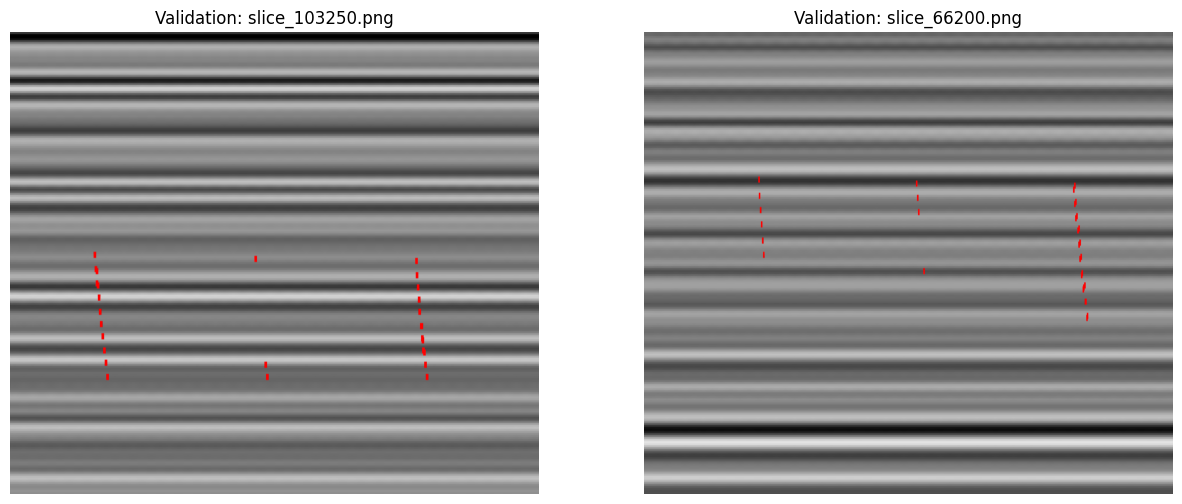

In [7]:
# ## 4. Validation Plot
# Inspect random samples to ensure the fault mask aligns with seismic discontinuities.

import random
files = os.listdir(f"{OUTPUT_DIR}/images")
random_files = random.sample(files, 2)

plt.figure(figsize=(15, 6))
for i, filename in enumerate(random_files):
    img = cv2.imread(f"{OUTPUT_DIR}/images/{filename}", 0)
    mask = cv2.imread(f"{OUTPUT_DIR}/masks/{filename}", 0)
    
    # Create Red Overlay
    overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    overlay[mask > 0] = [255, 0, 0] # Red Overlay

    plt.subplot(1, 2, i+1)
    plt.imshow(overlay, aspect='auto')
    plt.title(f"Validation: {filename}")
    plt.axis('off')
plt.show()